# Libraries and Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/CI for PD")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy import linalg as la
import datetime as dt
from sklearn.preprocessing import LabelEncoder

# Reading data

In [4]:
ratings_mapping = pd.read_csv("ratings_mapping.csv")
ratings_mapping.head()

,RatingSymbol,RatingNumber
0,AAA,0
1,AA+,1
2,AA,2
3,AA-,3
4,A+,4


In [5]:
ratings_data = pd.read_csv("issuer_credit_ratings_cleaned_local_currency_lt.csv")
ratings_data.head()

,rating,rating_action_date,obligor_name,rating_outlook
0,B+,2014-09-15,1011778 B.C. Unlimited Liability Company,Stable
1,B+,2015-06-08,1011778 B.C. Unlimited Liability Company,Stable
2,B+,2016-06-29,1011778 B.C. Unlimited Liability Company,Stable
3,B+,2017-02-14,1011778 B.C. Unlimited Liability Company,Stable
4,B+,2017-02-24,1011778 B.C. Unlimited Liability Company,Stable


In [6]:
# https://github.com/dpicone1/Estimating_Credit_Rating_Transition_Matrices_Hazard_Vs_Cohort/blob/master/TransitionClassFile.py
# the default rating symbol is D
# the default rating index  is 20

# the NR rating symbol is NR
# the NR rating index  is 21

# There are 21 initial states AAA, AA+, AA, AA-, A+, A, A-, BBB+, BBB, BBB-, BB+,
#                            BB, BB-, B+, B, B-, CCC+, CCC, CCC-, CC, D
# and 22 final states         AAA, AA+, AA, AA-, A+, A, A-, BBB+, BBB, BBB-, BB+,
#                            BB, BB-, B+, B, B-, CCC+, CCC, CCC-, CC, D, NR

class TransitionClass(object):
    def __init__(self, Dati, yend):

        #Dati is a dataframe containing the info to be processed
        #yend  is final year of the analysis
        self.MyDati = Dati
        self.MyDati = self.MyDati.copy()

        self.MyDati['Year']     = pd.DatetimeIndex(self.MyDati['Date']).year
        self.MyDati['TimeDiff'] = self.MyDati['Date'].diff()

        self.defautYes = False #The general status is that the loan/bond has not defaulted for the cohort model
        self.NRYes     = False #The general status is that the loan/bond is not NR for the cohort model

        self.DefaultedCheck()# check if the data contains a default
        self.NRCheck()       # check if the data contains a NR

        self.size      = len(self.MyDati)
        self.yend      = yend
        self.ybeg      = (self.MyDati.iloc[0].Date).year


    def DefaultedCheck(self):
        # Is there a default?
        self.defaulted     = self.MyDati[self.MyDati['RatingSymbol'] == 'D']
        self.defaultedSize = len(self.defaulted)

        if (self.defaultedSize > 0):

            # remove all the data after the obligor has defaulted
            DefaultDate = self.MyDati[self.MyDati['RatingSymbol'] == 'D']
            date = DefaultDate.iloc[0].Date
            self.MyDati = self.MyDati.drop(self.MyDati[self.MyDati['Date'] > date].index)

            # After removing all addtional data after defaut,
            # we should have only one defaulted record, the first one
            self.defaulted     = self.MyDati[self.MyDati['RatingSymbol'] == 'D']
            self.defaultedSize = len(self.defaulted)
            self.defaultyear = self.defaulted.iloc[0].Year
            self.defaultYes  = True

    def NRCheck(self):
        # Is there a NR without a previous Default?
        self.NRSize = 0
        self.NR     = self.MyDati[self.MyDati['RatingSymbol'] == 'NR']

        if (len(self.NR) > 0 & self.defaultedSize == 1): # Remove the NR record. We do not need it as we stop
            # as soon as the borrower defaults
            self.MyDati = self.MyDati.drop(self.MyDati[self.MyDati['RatingSymbol'] == 'NR'].index)

        if (len(self.NR) > 0 & self.defaultedSize == 0): # only if there is no default, otherwise the default will
            # overseed and stop the algo as soon as there is a default event

            # The obligor might have several NR or after an NR status might come a rating from AAA to C.
            # We remove all the data after the first NR.

            NRDate = self.MyDati[self.MyDati['RatingSymbol'] == 'NR']
            date = NRDate.iloc[0].Date
            self.MyDati = self.MyDati.drop(self.MyDati[self.MyDati['Date'] > date].index)

            # After removing all addtional NR, we should have only one NR record, the oldest one
            self.NR     = self.MyDati[self.MyDati['RatingSymbol'] == 'NR']
            self.NRSize = len(self.NR)
            self.NRyear = self.NR.iloc[0].Year
            self.NRYes  = True

    def Cohort(self):

        self.RatingsBeg = [self.MyDati.iloc[0].RatingSymbol] # containing the rating symbol at the beginning of the period
        self.RatingsEnd = []                                 # containing the rating symbol at the end of the period

        self.RatingsBegIndex = [self.MyDati.iloc[0].RatingNumber]# containing the rating index at the beginning of the period
        self.RatingsEndIndex = []                                # containing the rating index at the end of the period

        if   (self.defaultedSize == 1):
            finalYear = min(self.yend, self.defaultyear)
        elif (self.NRSize > 0):
            finalYear = min(self.yend, self.NRyear)
        else:
            finalYear = self.yend

        for i in range(self.ybeg, finalYear + 1):

            self.MyDatiLoop = self.MyDati[self.MyDati['Year'] == i]

            if(len(self.MyDatiLoop) > 0):
                dateCond         = max(self.MyDatiLoop.Date)
                self.MyDatiLoop2 = self.MyDatiLoop[self.MyDatiLoop['Date'] == dateCond]
                self.RatingsEnd.append(self.MyDatiLoop2.iloc[0].RatingSymbol)
                self.RatingsEndIndex.append(self.MyDatiLoop2.iloc[0].RatingNumber)

            else:
                self.RatingsEnd.append(self.MyDatiLoop2.iloc[0].RatingSymbol)
                self.RatingsEndIndex.append(self.MyDatiLoop2.iloc[0].RatingNumber)

            self.RatingsBeg.append(self.MyDatiLoop2.iloc[0].RatingSymbol)
            self.RatingsBegIndex.append(self.MyDatiLoop2.iloc[0].RatingNumber)

            if(self.RatingsEnd[-1] == 'D' or self.RatingsEnd[-1] == 'NR' ):
                break

        if(self.defautYes):
            self.RatingsEnd[-1]      = 'D'
            self.RatingsEndIndex[-1] = 20

        if(self.NRYes):
            self.RatingsEnd[-1]      = 'NR'
            self.RatingsEndIndex[-1] = 21

        self.RatingsBeg      = self.RatingsBeg[:-1]
        self.RatingsBegIndex = self.RatingsBegIndex[:-1]

    def CohortTransitionMatrix(self):
        self.TransMatrix = np.zeros([21, 22])
        self.TransDen    = np.zeros([21])

        for i in range(len(self.RatingsEndIndex)):
            self.TransMatrix[self.RatingsBegIndex[i], self.RatingsEndIndex[i]] +=1
            self.TransDen[self.RatingsBegIndex[i]] +=1

    def HazardModel(self):

        self.TransDenLambda  = np.zeros([21]) # containing the denominator Hazard Model

        self.DefaultYesHazard = False

        for i in range(1, self.size):

            valore = self.MyDati.iloc[i].TimeDiff.days / 365
            self.TransDenLambda[self.MyDati.iloc[i - 1].RatingNumber] += valore

            if (self.MyDati.iloc[i].RatingSymbol == 'D' or self.MyDati.iloc[i].RatingSymbol == 'NR'):
                self.DefaultYesHazard = True
                break

        #first period
        dbeg = dt.date(self.MyDati.iloc[0].Year, 1, 1)
        valoreBeg = (self.MyDati.iloc[0].Date - dbeg).days/365.0
        self.TransDenLambda[self.MyDati.iloc[0].RatingNumber] += valoreBeg

        # Last Period Analysis
        dfinal = dt.date(self.yend, 12, 31)
        if(self.DefaultYesHazard == False):
            valoreEnd = (dfinal - self.MyDati.iloc[self.size - 1].Date).days/365.0
            self.TransDenLambda[self.MyDati.iloc[self.size - 1].RatingNumber] += valoreEnd

In [7]:
TransitionData = ratings_data[["obligor_name", "rating_action_date", "rating"]]
TransitionData.columns = ["Id", "Date", "RatingSymbol"]
TransitionData = TransitionData.sort_values(by=["Id", "Date"])
le = LabelEncoder()
TransitionData.Id = le.fit_transform(TransitionData.Id)
print (TransitionData.head(2))
print ("---------------------------")
print (TransitionData.tail(2))
size = len(TransitionData)

   Id        Date RatingSymbol
0   0  2014-09-15           B+
1   0  2015-06-08           B+
---------------------------
         Id        Date RatingSymbol
77554  8526  2014-11-05          BB-
77555  8526  2015-02-17           NR


In [8]:
print (TransitionData.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77579 entries, 0 to 77555
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            77579 non-null  int64 
 1   Date          77579 non-null  object
 2   RatingSymbol  77579 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.4+ MB
None


In [9]:
print (TransitionData.dtypes)

Id               int64
Date            object
RatingSymbol    object
dtype: object


In [10]:
MappingData = ratings_mapping
MappingData.columns = ["RatingSymbol", "RatingNumber"]
MappingData = MappingData.sort_values(by=["RatingNumber"])
print (MappingData.head(2))
print ("---------------------------")
print (MappingData.tail(2))

  RatingSymbol  RatingNumber
0          AAA             0
1          AA+             1
---------------------------
   RatingSymbol  RatingNumber
20            D            20
21           NR            21


In [11]:
TransitionData = pd.merge(TransitionData, MappingData, on='RatingSymbol', how='left')
TransitionData.head()

,Id,Date,RatingSymbol,RatingNumber
0,0,2014-09-15,B+,13
1,0,2015-06-08,B+,13
2,0,2016-06-29,B+,13
3,0,2017-02-14,B+,13
4,0,2017-02-24,B+,13


In [12]:
TransitionData['Date'] = pd.to_datetime(TransitionData['Date'])

In [13]:
TransitionData.head()

,Id,Date,RatingSymbol,RatingNumber
0,0,2014-09-15,B+,13
1,0,2015-06-08,B+,13
2,0,2016-06-29,B+,13
3,0,2017-02-14,B+,13
4,0,2017-02-24,B+,13


In [14]:
TransitionData['Date'] = TransitionData['Date'].dt.date

In [15]:
TransitionData.head()

,Id,Date,RatingSymbol,RatingNumber
0,0,2014-09-15,B+,13
1,0,2015-06-08,B+,13
2,0,2016-06-29,B+,13
3,0,2017-02-14,B+,13
4,0,2017-02-24,B+,13


In [16]:
maxID = TransitionData.iloc[size-1].Id
maxID

8526

In [17]:
yend = max(TransitionData.Date)
yend = yend.year
yend

2021

In [18]:
# The arrays containing the outputs
TransMatrixResults       = np.zeros([21, 22])
TransDenResults          = np.zeros([21])
TransDenLambdaResults    = np.zeros([21])

In [19]:
# Run the algo for all obligors
for i in range(1, maxID + 1):

    MyDati = TransitionData[TransitionData['Id'] == i]
    print ("processing ID borrower No: ", i)

    if (len(MyDati) == 1 and MyDati.iloc[0].RatingSymbol == 'NR'):
        # when this is true the data is not processed as it contains only one record, equal to state NR
        print("Only one NR Rating event on Borrower No: ", i)

    else:
        trans = TransitionClass(MyDati, yend)
        trans.Cohort()
        trans.CohortTransitionMatrix()
        trans.HazardModel()

        TransMatrixResults    = trans.TransMatrix + TransMatrixResults
        TransDenResults       = trans.TransDen    + TransDenResults #NR
        TransDenLambdaResults = trans.TransDenLambda + TransDenLambdaResults

Streaming output truncated to the last 5000 lines.
processing ID borrower No:  3527
processing ID borrower No:  3528
processing ID borrower No:  3529
processing ID borrower No:  3530
processing ID borrower No:  3531
processing ID borrower No:  3532
processing ID borrower No:  3533
processing ID borrower No:  3534
processing ID borrower No:  3535
processing ID borrower No:  3536
processing ID borrower No:  3537
processing ID borrower No:  3538
processing ID borrower No:  3539
processing ID borrower No:  3540
processing ID borrower No:  3541
processing ID borrower No:  3542
processing ID borrower No:  3543
processing ID borrower No:  3544
processing ID borrower No:  3545
processing ID borrower No:  3546
processing ID borrower No:  3547
processing ID borrower No:  3548
processing ID borrower No:  3549
processing ID borrower No:  3550
processing ID borrower No:  3551
processing ID borrower No:  3552
processing ID borrower No:  3553
processing ID borrower No:  3554
processing ID borrower No

In [20]:
TransDenResults #sum n_ij its our NR

array([  138.,    87.,   366.,   865.,  1430.,  2590.,  4145.,  4858.,
        6055.,  5068.,  3406.,  3990.,  4614.,  6054., 10953.,  4865.,
        1236.,   496.,   247.,   145.,     0.])

In [21]:
TransDenLambdaResults

array([  133.60547945,    87.        ,   354.24383562,   841.88493151,
        1402.48767123,  2598.98356164,  4132.31780822,  4852.58082192,
        6055.08767123,  4985.28493151,  3408.77808219,  3919.45205479,
        4504.49041096,  5755.66849315, 10239.53972603,  4803.07123288,
        1323.03561644,   502.45479452,   250.41369863,   150.89589041,
           0.        ])

In [22]:
# In case you need to see the transitions
pij = pd.DataFrame(TransMatrixResults)
pij.to_csv('pij.csv')

In [23]:
TransMatrixResults

array([[1.290e+02, 8.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 7.700e+01, 7.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 3.000e+00, 3.160e+02, 3.800e+01, 3.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00],
       [0.000e+00, 0.000e+00, 2.700e+01, 7.290e+02, 8.200e+01, 1.500e+01,
        1.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+0

In [24]:
pij.columns =["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", "Default",'NR']

# Change the row indexes
pij.index = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", "Default",]
pij

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,129.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA+,0.0,77.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA,0.0,3.0,316.0,38.0,3.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
AA-,0.0,0.0,27.0,729.0,82.0,15.0,1.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
A+,0.0,0.0,1.0,54.0,1235.0,96.0,25.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
A,0.0,0.0,0.0,2.0,74.0,2265.0,162.0,45.0,9.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
A-,0.0,0.0,0.0,2.0,1.0,141.0,3642.0,257.0,38.0,11.0,...,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0
BBB+,0.0,0.0,0.0,1.0,1.0,23.0,269.0,4185.0,264.0,35.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0
BBB,0.0,0.0,1.0,0.0,1.0,1.0,35.0,329.0,5209.0,312.0,...,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0
BBB-,0.0,0.0,0.0,1.0,2.0,3.0,6.0,30.0,391.0,4227.0,...,30.0,9.0,3.0,2.0,3.0,0.0,0.0,0.0,2.0,101.0


In [25]:
RatingMgrationCohort = np.zeros([21, 22])
RatingMgrationHazard = np.zeros([21, 22])
for i in range(21):
    for j in range(22):
        RatingMgrationCohort[i,j] = TransMatrixResults[i,j] / TransDenResults[i]
        RatingMgrationHazard[i,j] = TransMatrixResults[i,j] / TransDenLambdaResults[i]

#Default Category
RatingMgrationHazard[20,20] = 1.0 # Absorbing
RatingMgrationHazard[20,:] = 0.0 # All the others = 0

<ipython-input-25-252351362324>:5: RuntimeWarning: invalid value encountered in double_scalars
  RatingMgrationCohort[i,j] = TransMatrixResults[i,j] / TransDenResults[i]
<ipython-input-25-252351362324>:6: RuntimeWarning: invalid value encountered in double_scalars
  RatingMgrationHazard[i,j] = TransMatrixResults[i,j] / TransDenLambdaResults[i]


## The Generator Matrix for the Hazard Approach

In [26]:
for i in range(21):
    RatingMgrationHazard[i,i] = 0
    RatingMgrationHazard[i,i] = -sum(RatingMgrationHazard[i,:])

In [27]:
RatingMgrationHazardDF = pd.DataFrame(RatingMgrationHazard)
# Change the column names
RatingMgrationHazardDF.columns =["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", "Default",'NR']

# Change the row indexes
RatingMgrationHazardDF.index = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", "Default"]

In [28]:
# printing the data frame
RatingMgrationHazardDF

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,-0.067363,0.059878,0.007485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AA+,0.000000,-0.114943,0.080460,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AA,0.000000,0.008469,-0.141146,0.107271,0.008469,0.000000,0.000000,0.005646,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011292
AA-,0.000000,0.000000,0.032071,-0.161542,0.097400,0.017817,0.001188,0.000000,0.003563,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009502
A+,0.000000,0.000000,0.000713,0.038503,-0.139039,0.068450,0.017825,0.001426,0.000713,0.001426,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009982
A,0.000000,0.000000,0.000000,0.000770,0.028473,-0.125049,0.062332,0.017314,0.003463,0.000385,...,0.000385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011543
A-,0.000000,0.000000,0.000000,0.000484,0.000242,0.034121,-0.121723,0.062193,0.009196,0.002662,...,0.000242,0.000726,0.000242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011616
BBB+,0.000000,0.000000,0.000000,0.000206,0.000206,0.004740,0.055434,-0.138689,0.054404,0.007213,...,0.000206,0.000412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014631
BBB,0.000000,0.000000,0.000165,0.000000,0.000165,0.000165,0.005780,0.054334,-0.139717,0.051527,...,0.001486,0.000165,0.000165,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016680
BBB-,0.000000,0.000000,0.000000,0.000201,0.000401,0.000602,0.001204,0.006018,0.078431,-0.168696,...,0.006018,0.001805,0.000602,0.000401,0.000602,0.000000,0.000000,0.000000,0.000401,0.020260


In [29]:
# Let's check. All Rows should add to ZERO!
RatingMgrationHazardDF.sum(axis=1)

AAA        4.336809e-18
AA+        0.000000e+00
AA         1.387779e-17
AA-        0.000000e+00
A+        -4.683753e-17
A         -5.204170e-18
A-        -3.469447e-18
BBB+      -1.214306e-17
BBB       -6.938894e-18
BBB-      -1.040834e-17
BB+       -2.428613e-17
BB         1.734723e-17
BB-        6.938894e-18
B+        -2.775558e-17
B         -1.387779e-17
B-        -2.775558e-17
CCC+       0.000000e+00
CCC       -2.775558e-17
CCC-       4.857226e-17
CC         0.000000e+00
Default    0.000000e+00
dtype: float64

## Cohort Approach Transition Matrix

In [30]:
# Let's prepare the Cohort Matrix
# add a zero row to the cohort matrix
row_to_be_added = np.zeros((22))
RatingMgrationCohort_V2 = np.vstack ((RatingMgrationCohort, row_to_be_added) )
RatingMgrationCohort_V2[21,21] = 1.0

#Default Category
RatingMgrationCohort_V2[20,:] = 0.0 # All the others = 0
RatingMgrationCohort_V2[20,20] = 1.0 # Absorbing

In [31]:
RatingMgrationCohortDF = pd.DataFrame(RatingMgrationCohort_V2)
# Change the column names
RatingMgrationCohortDF.columns =["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", 'Default', 'NR']

# Change the row indexes
RatingMgrationCohortDF.index = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", 'Default', 'NR']

# printing the data frame
RatingMgrationCohortDF

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,0.934783,0.057971,0.007246,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AA+,0.000000,0.885057,0.080460,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AA,0.000000,0.008197,0.863388,0.103825,0.008197,0.000000,0.000000,0.005464,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010929
AA-,0.000000,0.000000,0.031214,0.842775,0.094798,0.017341,0.001156,0.000000,0.003468,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009249
A+,0.000000,0.000000,0.000699,0.037762,0.863636,0.067133,0.017483,0.001399,0.000699,0.001399,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009790
A,0.000000,0.000000,0.000000,0.000772,0.028571,0.874517,0.062548,0.017375,0.003475,0.000386,...,0.000386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011583
A-,0.000000,0.000000,0.000000,0.000483,0.000241,0.034017,0.878649,0.062002,0.009168,0.002654,...,0.000241,0.000724,0.000241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011580
BBB+,0.000000,0.000000,0.000000,0.000206,0.000206,0.004734,0.055373,0.861466,0.054343,0.007205,...,0.000206,0.000412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014615
BBB,0.000000,0.000000,0.000165,0.000000,0.000165,0.000165,0.005780,0.054335,0.860281,0.051528,...,0.001486,0.000165,0.000165,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016680
BBB-,0.000000,0.000000,0.000000,0.000197,0.000395,0.000592,0.001184,0.005919,0.077151,0.834057,...,0.005919,0.001776,0.000592,0.000395,0.000592,0.000000,0.000000,0.000000,0.000395,0.019929


In [32]:
# All rows should add to ONE!
RatingMgrationCohortDF.sum(axis=1)

AAA        1.0
AA+        1.0
AA         1.0
AA-        1.0
A+         1.0
A          1.0
A-         1.0
BBB+       1.0
BBB        1.0
BBB-       1.0
BB+        1.0
BB         1.0
BB-        1.0
B+         1.0
B          1.0
B-         1.0
CCC+       1.0
CCC        1.0
CCC-       1.0
CC         1.0
Default    1.0
NR         1.0
dtype: float64

In [33]:
table1 = pd.DataFrame({'Cohort': RatingMgrationCohortDF['Default'][:-2]*10000, 'Duration': RatingMgrationHazardDF['Default'][:-1]*10000})

In [34]:
table1['Ratio'] = table1.apply(lambda row: 0 if (row['Cohort'] == 0 and row['Duration'] == 0) else row['Cohort'] / row['Duration'] * 100, axis=1)

In [35]:
table1

,Cohort,Duration,Ratio
AAA,0.000000,0.000000,0.000000
AA+,0.000000,0.000000,0.000000
AA,0.000000,0.000000,0.000000
AA-,0.000000,0.000000,0.000000
A+,0.000000,0.000000,0.000000
A,0.000000,0.000000,0.000000
A-,0.000000,0.000000,0.000000
BBB+,0.000000,0.000000,0.000000
BBB,0.000000,0.000000,0.000000
BBB-,3.946330,4.011807,98.367895


In [36]:
NR = pd.DataFrame(pij.sum(axis=1))

In [37]:
NR.columns = ["NR"]

In [38]:
NR

,NR
AAA,138.0
AA+,87.0
AA,366.0
AA-,865.0
A+,1430.0
A,2590.0
A-,4145.0
BBB+,4858.0
BBB,6055.0
BBB-,5068.0


In [39]:
def compute_ci_wald(pd, nr,alpha=0.05):
  ## compute z_alpha
  z_alpha = stats.norm.ppf(1-alpha/2)

  ## compute the standard error
  se = np.sqrt(pd*(1-pd)/nr)

  ## compute the confidence interval
  ci = pd - z_alpha*se, pd + z_alpha*se

  return ci

In [40]:
wald_ci_raw = RatingMgrationCohortDF[["Default"]].join(NR).rename(columns={"RatingSymbol":"NR"}).apply(lambda x:\
                                                                                                      compute_ci_wald(x.values[0], x.values[1]),
                                                                                                      axis=1)
wald_ci_df = pd.DataFrame(wald_ci_raw.tolist(), columns = ["lower", "upper"], index=wald_ci_raw.index)
wald_ci_df.drop(["Default", "NR"], axis=0, inplace=True)
wald_ci_df = wald_ci_df*10000

<ipython-input-39-f1b6421066c3>:6: RuntimeWarning: invalid value encountered in double_scalars
  se = np.sqrt(pd*(1-pd)/nr)


In [41]:
wald_ci_df['lenth'] = wald_ci_df['upper'] - wald_ci_df['lower']
wald_ci_df['mid'] = (wald_ci_df['upper'] + wald_ci_df['lower'])/2

In [42]:
wald_ci_df[9:]

,lower,upper,lenth,mid
BBB-,-1.521825,9.414484,10.936309,3.946330
BB+,0.241851,23.246111,23.004260,11.743981
BB,-0.986167,16.023761,17.009929,7.518797
BB-,27.804285,67.557657,39.753373,47.680971
B+,41.484129,80.749105,39.264975,61.116617
B,65.263123,99.075414,33.812291,82.169269
B-,244.579057,339.182505,94.603448,291.880781
CCC+,1145.343266,1524.559646,379.216380,1334.951456
CCC,1985.244089,2732.497847,747.253758,2358.870968
CCC-,2501.340668,3652.505486,1151.164818,3076.923077


In [43]:
wald_ci_df

,lower,upper,lenth,mid
AAA,0.000000,0.000000,0.000000,0.000000
AA+,0.000000,0.000000,0.000000,0.000000
AA,0.000000,0.000000,0.000000,0.000000
AA-,0.000000,0.000000,0.000000,0.000000
A+,0.000000,0.000000,0.000000,0.000000
A,0.000000,0.000000,0.000000,0.000000
A-,0.000000,0.000000,0.000000,0.000000
BBB+,0.000000,0.000000,0.000000,0.000000
BBB,0.000000,0.000000,0.000000,0.000000
BBB-,-1.521825,9.414484,10.936309,3.946330


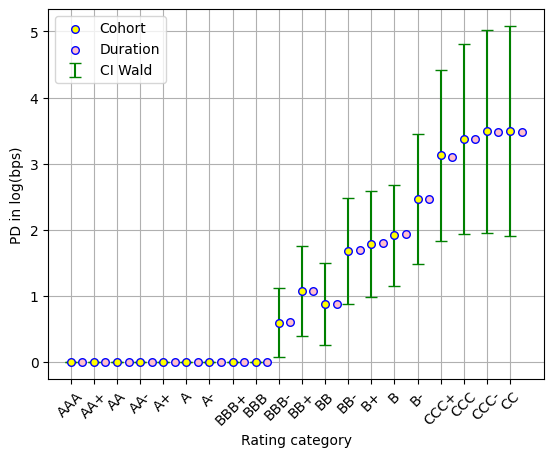

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Exemple de données
x_labels = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-", "CC"]

# Créer un ensemble de positions entières pour chaque label avec un espacement de 2
x_positions = np.arange(0, len(x_labels) * 6, 6)

y = np.log10(list(np.ones(9)) + list(wald_ci_df['mid'][9:]))
confidence_interval = np.log10(list(np.ones(9)) + list(wald_ci_df['lenth'][9:]))/2

# Tracer les intervalles de confiance sous forme de segments
plt.errorbar(x_positions, y, yerr=confidence_interval, fmt='none', ecolor='green', capsize=4, label='CI Wald', zorder=2)

# Ajouter des étiquettes et un titre
plt.xlabel('Rating category')
plt.ylabel('PD in log(bps)')
plt.grid(True)

# Ajouter un deuxième graphique pour la colonne 'Default' sous forme de disques entourés en jaune
y2 = list(np.log10(list(np.ones(9)) + list(table1['Cohort'][9:])))
y3 = list(np.log10(list(np.ones(9)) + list(table1['Duration'][9:])))

# Tracer les points sous forme de disques entourés en jaune à droite
plt.scatter(x_positions, y2, s=30, edgecolors='blue', facecolors='yellow', label='Cohort', zorder=3)

# Tracer les points sous forme de disques entourés en rose à gauche
plt.scatter(x_positions +3, y3, s=30, edgecolors='blue', facecolors='pink', label='Duration', zorder=3)

# Placer les x-labels au milieu entre les barres d'erreur et les points
plt.xticks(x_positions, x_labels, rotation=45, ha='center')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()


In [45]:
new_lower = pd.DataFrame([x if x>=0 else 10**-6 for x in wald_ci_df['lower']])

In [46]:
new_lower.index = wald_ci_df.index
new_lower.columns = ['lower']

In [47]:
new_wald_ci_df = pd.concat([new_lower, pd.DataFrame(wald_ci_df['upper'])], axis=1)

In [48]:
new_wald_ci_df

,lower,upper
AAA,0.000000,0.000000
AA+,0.000000,0.000000
AA,0.000000,0.000000
AA-,0.000000,0.000000
A+,0.000000,0.000000
A,0.000000,0.000000
A-,0.000000,0.000000
BBB+,0.000000,0.000000
BBB,0.000000,0.000000
BBB-,0.000001,9.414484


In [49]:
new_wald_ci_df['lower'] = new_wald_ci_df['lower'].replace(0, 1)
new_wald_ci_df['upper'] = new_wald_ci_df['upper'].replace(0, 1)

In [50]:
new_wald_ci_df

,lower,upper
AAA,1.000000,1.000000
AA+,1.000000,1.000000
AA,1.000000,1.000000
AA-,1.000000,1.000000
A+,1.000000,1.000000
A,1.000000,1.000000
A-,1.000000,1.000000
BBB+,1.000000,1.000000
BBB,1.000000,1.000000
BBB-,0.000001,9.414484


In [51]:
new_wald_ci_df['lenth'] =  np.log10(new_wald_ci_df['upper']) - np.log10(new_wald_ci_df['lower'])
new_wald_ci_df['mid'] = (np.log10(new_wald_ci_df['upper']) + np.log10(new_wald_ci_df['lower']))/2

In [52]:
new_wald_ci_df

,lower,upper,lenth,mid
AAA,1.000000,1.000000,0.000000,0.000000
AA+,1.000000,1.000000,0.000000,0.000000
AA,1.000000,1.000000,0.000000,0.000000
AA-,1.000000,1.000000,0.000000,0.000000
A+,1.000000,1.000000,0.000000,0.000000
A,1.000000,1.000000,0.000000,0.000000
A-,1.000000,1.000000,0.000000,0.000000
BBB+,1.000000,1.000000,0.000000,0.000000
BBB,1.000000,1.000000,0.000000,0.000000
BBB-,0.000001,9.414484,6.973797,-2.513102


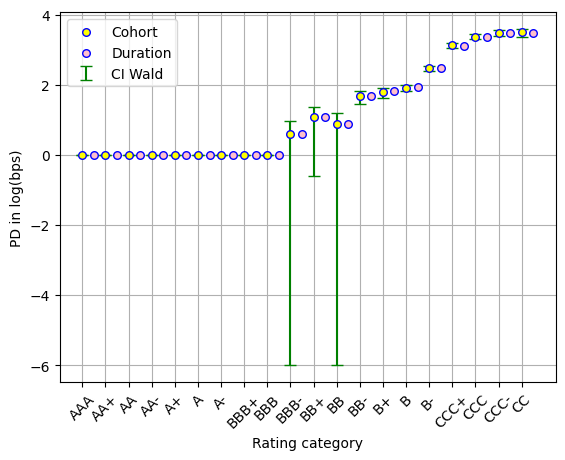

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Exemple de données
x_labels = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-", "CC"]

# Créer un ensemble de positions entières pour chaque label avec un espacement de 2
x_positions = np.arange(0, len(x_labels) * 6, 6)

y = list(new_wald_ci_df['mid'])
confidence_interval = list(new_wald_ci_df['lenth']/2)

# Tracer les intervalles de confiance sous forme de segments
plt.errorbar(x_positions, y, yerr=confidence_interval, fmt='none', ecolor='green', capsize=4, label='CI Wald', zorder=2)

# Ajouter des étiquettes et un titre
plt.xlabel('Rating category')
plt.ylabel('PD in log(bps)')
plt.grid(True)

# Ajouter un deuxième graphique pour la colonne 'Default' sous forme de disques entourés en jaune
y2 = list(np.log10(list(np.ones(9)) + list(table1['Cohort'][9:])))
y3 = list(np.log10(list(np.ones(9)) + list(table1['Duration'][9:])))

# Tracer les points sous forme de disques entourés en jaune à droite
plt.scatter(x_positions, y2, s=30, edgecolors='blue', facecolors='yellow', label='Cohort', zorder=3)

# Tracer les points sous forme de disques entourés en rose à gauche
plt.scatter(x_positions +3, y3, s=30, edgecolors='blue', facecolors='pink', label='Duration', zorder=3)

# Placer les x-labels au milieu entre les barres d'erreur et les points
plt.xticks(x_positions, x_labels, rotation=45, ha='center')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()


#### Agresti and Coul CI

In [54]:
def compute_ci_agresti(pd,nr, alpha=0.05):
  ## compute z_alpha
  z_alpha = stats.norm.ppf(1-alpha/2)

  ## compute the number of people who migrated from rating to default
  nrd = nr * pd

  ## compute the corrected nr and nrd
  nr_tilde = nr + z_alpha**2
  nrd_tilde = nrd + z_alpha**2/2

  ## compute the corrected probability
  pd_tilde = nrd_tilde/nr_tilde

  ## compute the standard error
  se = np.sqrt(pd_tilde*(1-pd_tilde)/nr_tilde)

  ## compute the confidence interval
  ci = pd_tilde - z_alpha*se, pd_tilde + z_alpha*se

  return ci

In [55]:
agresti_ci_raw = RatingMgrationCohortDF[["Default"]].join(NR).rename(columns={"RatingSymbol":"NR"}).drop(["Default", "NR"], axis=0).apply(lambda x:\
                                                                                                      compute_ci_agresti(x.values[0], x.values[1]),
                                                                                                      axis=1)
agresti_ci_df = pd.DataFrame(agresti_ci_raw.tolist(), columns = ["lower", "upper"], index=agresti_ci_raw.index)
# agresti_ci_df.drop(["Default", "NR"], axis=0, inplace=True)

agresti_ci_df = agresti_ci_df*10000

In [56]:
agresti_ci_df['lenth'] = agresti_ci_df['upper'] - agresti_ci_df['lower']
agresti_ci_df['mid'] = (agresti_ci_df['upper'] + agresti_ci_df['lower'])/2

In [57]:
agresti_ci_df

,lower,upper,lenth,mid
AAA,-54.789207,325.616852,380.406059,135.413822
AA+,-84.402226,507.277295,591.679521,211.437535
AA,-21.320745,125.188462,146.509207,51.933859
AA-,-9.122355,53.335932,62.458287,22.106788
A+,-5.535983,32.327361,37.863344,13.395689
A,-3.063357,17.873279,20.936636,7.404961
A-,-1.916109,11.175221,13.091331,4.629556
BBB+,-1.635297,9.536540,11.171837,3.950621
BBB,-1.312399,7.652652,8.965051,3.170127
BBB-,0.081505,15.379268,15.297763,7.730386


In [58]:
agresti_ci_df

,lower,upper,lenth,mid
AAA,-54.789207,325.616852,380.406059,135.413822
AA+,-84.402226,507.277295,591.679521,211.437535
AA,-21.320745,125.188462,146.509207,51.933859
AA-,-9.122355,53.335932,62.458287,22.106788
A+,-5.535983,32.327361,37.863344,13.395689
A,-3.063357,17.873279,20.936636,7.404961
A-,-1.916109,11.175221,13.091331,4.629556
BBB+,-1.635297,9.536540,11.171837,3.950621
BBB,-1.312399,7.652652,8.965051,3.170127
BBB-,0.081505,15.379268,15.297763,7.730386


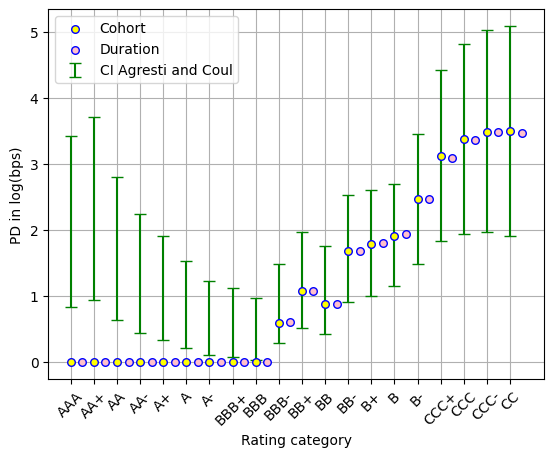

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Exemple de données
x_labels = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-", "CC"]

# Créer un ensemble de positions entières pour chaque label avec un espacement de 2
x_positions = np.arange(0, len(x_labels) * 6, 6)

y = np.log10(list(agresti_ci_df['mid']))
confidence_interval = np.log10(list(agresti_ci_df['lenth']))/2

# Tracer les intervalles de confiance sous forme de segments
plt.errorbar(x_positions, y, yerr=confidence_interval, fmt='none', ecolor='green', capsize=4, label='CI Agresti and Coul', zorder=2)

# Ajouter des étiquettes et un titre
plt.xlabel('Rating category')
plt.ylabel('PD in log(bps)')
plt.grid(True)

# Ajouter un deuxième graphique pour la colonne 'Default' sous forme de disques entourés en jaune
y2 = list(np.log10(list(np.ones(9)) + list(table1['Cohort'][9:])))
y3 = list(np.log10(list(np.ones(9)) + list(table1['Duration'][9:])))

# Tracer les points sous forme de disques entourés en jaune à droite
plt.scatter(x_positions, y2, s=30, edgecolors='blue', facecolors='yellow', label='Cohort', zorder=3)

# Tracer les points sous forme de disques entourés en rose à gauche
plt.scatter(x_positions +3, y3, s=30, edgecolors='blue', facecolors='pink', label='Duration', zorder=3)

# Placer les x-labels au milieu entre les barres d'erreur et les points
plt.xticks(x_positions, x_labels, rotation=45, ha='center')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()


In [60]:
new_lower = pd.DataFrame([x if x>0 else 10**-6 for x in agresti_ci_df['lower']])

In [61]:
new_lower.index = agresti_ci_df.index
new_lower.columns = ['lower']

In [62]:
new_agresti_ci_df = pd.concat([new_lower, pd.DataFrame(agresti_ci_df['upper'])], axis=1)

In [63]:
new_agresti_ci_df['lenth'] = np.log10(new_agresti_ci_df['upper']) - np.log10(new_agresti_ci_df['lower'])
new_agresti_ci_df['mid'] = (np.log10(new_agresti_ci_df['upper']) + np.log10(new_agresti_ci_df['lower']))/2

In [64]:
new_agresti_ci_df

,lower,upper,lenth,mid
AAA,0.000001,325.616852,8.512707,-1.743647
AA+,0.000001,507.277295,8.705245,-1.647377
AA,0.000001,125.188462,8.097564,-1.951218
AA-,0.000001,53.335932,7.727020,-2.136490
A+,0.000001,32.327361,7.509570,-2.245215
A,0.000001,17.873279,7.252204,-2.373898
A-,0.000001,11.175221,7.048256,-2.475872
BBB+,0.000001,9.536540,6.979391,-2.510305
BBB,0.000001,7.652652,6.883812,-2.558094
BBB-,0.081505,15.379268,2.275752,0.049060


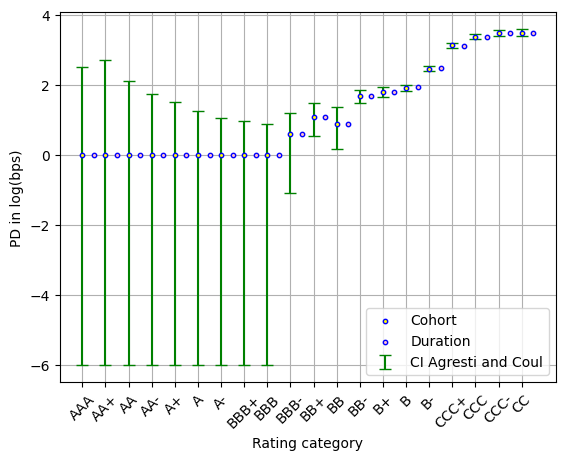

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Exemple de données
x_labels = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-", "CC"]

# Créer un ensemble de positions entières pour chaque label avec un espacement de 2
x_positions = np.arange(0, len(x_labels) * 6, 6)

y = list(new_agresti_ci_df['mid'])
confidence_interval = list(new_agresti_ci_df['lenth']/2)

# Tracer les intervalles de confiance sous forme de segments
plt.errorbar(x_positions, y, yerr=confidence_interval, fmt='none', ecolor='green', capsize=4, label='CI Agresti and Coul', zorder=2)

# Ajouter des étiquettes et un titre
plt.xlabel('Rating category')
plt.ylabel('PD in log(bps)')
plt.grid(True)

# Ajouter un deuxième graphique pour la colonne 'Default' sous forme de disques entourés en jaune
y2 = list(np.log10(list(np.ones(9)) + list(table1['Cohort'][9:])))
y3 = list(np.log10(list(np.ones(9)) + list(table1['Duration'][9:])))

# Tracer les points sous forme de disques entourés en jaune à droite
plt.scatter(x_positions, y2, s=10, edgecolors='blue', facecolors='yellow', label='Cohort', zorder=3)

# Tracer les points sous forme de disques entourés en rose à gauche
plt.scatter(x_positions +3, y3, s=10, edgecolors='blue', facecolors='pink', label='Duration', zorder=3)

# Placer les x-labels au milieu entre les barres d'erreur et les points
plt.xticks(x_positions, x_labels, rotation=45, ha='center')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()


#### Clopper Pearson CI

In [66]:
def compute_ci_clopper(pd,nr, alpha=0.05):
  ## compute nrd
  nrd = int(nr * pd)

  ## binomial test
  result = stats.binomtest(k=nrd, n=int(nr), p=pd)

  ## compute the confidence interval
  ci = result.proportion_ci(method="exact", confidence_level=1-alpha)

  return ci.low, ci.high

In [67]:
clopper_ci_raw = RatingMgrationCohortDF[["Default"]].join(NR).rename(columns={"RatingSymbol":"NR"}).drop(["Default", "NR"], axis=0).apply(lambda x:\
                                                                                                      compute_ci_clopper(x.values[0], x.values[1]),
                                                                                                      axis=1)
clopper_ci_df = pd.DataFrame(clopper_ci_raw.tolist(), columns = ["lower", "upper"], index=clopper_ci_raw.index)
# clopper_ci_df.drop(["Default", "NR"], axis=0, inplace=True)
clopper_ci_df
clopper_ci_df = clopper_ci_df*10000

In [68]:
clopper_ci_df['lenth'] = clopper_ci_df['upper'] - clopper_ci_df['lower']
clopper_ci_df['mid'] = (clopper_ci_df['upper'] + clopper_ci_df['lower'])/2

In [69]:
clopper_ci_df

,lower,upper,lenth,mid
AAA,0.000000,263.768993,263.768993,131.884497
AA+,0.000000,415.145660,415.145660,207.572830
AA,0.000000,100.282837,100.282837,50.141418
AA-,0.000000,42.555200,42.555200,21.277600
A+,0.000000,25.763116,25.763116,12.881558
A,0.000000,14.232640,14.232640,7.116320
A-,0.000000,8.895630,8.895630,4.447815
BBB+,0.000000,7.590530,7.590530,3.795265
BBB,0.000000,6.090431,6.090431,3.045216
BBB-,0.477955,14.248154,13.770200,7.363054


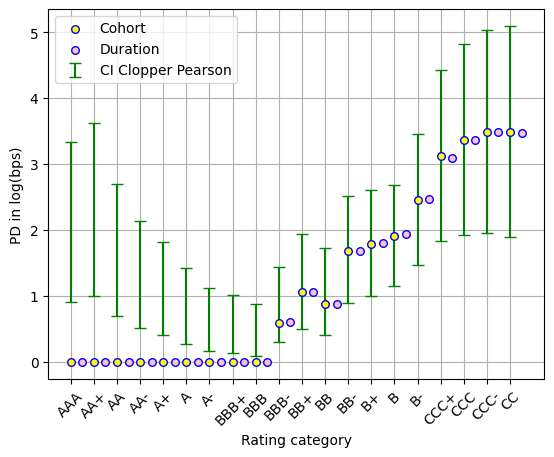

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Exemple de données
x_labels = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-", "CC"]

# Créer un ensemble de positions entières pour chaque label avec un espacement de 2
x_positions = np.arange(0, len(x_labels) * 6, 6)

y = np.log10(list(clopper_ci_df['mid']))
confidence_interval = np.log10(list(clopper_ci_df['lenth']))/2

# Tracer les intervalles de confiance sous forme de segments
plt.errorbar(x_positions, y, yerr=confidence_interval, fmt='none', ecolor='green', capsize=4, label='CI Clopper Pearson', zorder=2)

# Ajouter des étiquettes et un titre
plt.xlabel('Rating category')
plt.ylabel('PD in log(bps)')
plt.grid(True)

# Ajouter un deuxième graphique pour la colonne 'Default' sous forme de disques entourés en jaune
y2 = list(np.log10(list(np.ones(9)) + list(table1['Cohort'][9:])))
y3 = list(np.log10(list(np.ones(9)) + list(table1['Duration'][9:])))

# Tracer les points sous forme de disques entourés en jaune à droite
plt.scatter(x_positions, y2, s=30, edgecolors='blue', facecolors='yellow', label='Cohort', zorder=3)

# Tracer les points sous forme de disques entourés en rose à gauche
plt.scatter(x_positions +3, y3, s=30, edgecolors='blue', facecolors='pink', label='Duration', zorder=3)

# Placer les x-labels au milieu entre les barres d'erreur et les points
plt.xticks(x_positions, x_labels, rotation=45, ha='center')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()


In [81]:
import pandas as pd

data = {
    'Mean PD': [6.043171e-14, 2.226557e-12, 2.335120e-08, 7.167092e-09, 1.284084e-06, 1.748886e-05,
           1.362459e-03, 2.262225e-03, 5.615497e-03, 9.871299e-02, 1.441063e+00, 2.556953e+00,
           1.208670e+01, 2.465935e+01, 3.019680e+01, 1.500952e+02, 7.276087e+02, 1.484037e+03,
           3.436359e+03, 7.444361e+03],
    'Lower': [0.0] * 20,
    'Upper': [0.0, 0.0, 1.377348e-21, 1.930951e-10, 7.026576e-08, 1.782727e-05, 6.314620e-04,
              3.280336e-03, 1.330158e-02, 1.437530e+00, 1.242763e+00, 1.140521e+01, 1.735529e+02,
              2.047367e+02, 1.472843e+02, 5.147183e+02, 2.141537e+03, 4.223862e+03, 1.033659e+04,
              2.057107e+04]
}

ci_boot = pd.DataFrame(data, index=['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-',
                               'BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC'])


In [82]:
ci_boot

,Mean PD,Lower,Upper
AAA,6.043171e-14,0.0,0.000000e+00
AA+,2.226557e-12,0.0,0.000000e+00
AA,2.335120e-08,0.0,1.377348e-21
AA-,7.167092e-09,0.0,1.930951e-10
A+,1.284084e-06,0.0,7.026576e-08
A,1.748886e-05,0.0,1.782727e-05
A-,1.362459e-03,0.0,6.314620e-04
BBB+,2.262225e-03,0.0,3.280336e-03
BBB,5.615497e-03,0.0,1.330158e-02
BBB-,9.871299e-02,0.0,1.437530e+00


In [98]:
boot_new_lower = pd.DataFrame(list(np.ones(2)) + [x if x>0 else 10**-6 for x in ci_boot['Lower'][2:]])

In [104]:
new_lower = pd.DataFrame([x if x>0 else 10**-6 for x in clopper_ci_df['lower']])

In [101]:
boot_new_lower.index = ci_boot.index
boot_new_lower.columns = ['Lower']

In [72]:
new_lower.index = clopper_ci_df.index
new_lower.columns = ['lower']

In [105]:
new_ci_boot = pd.concat([boot_new_lower, pd.DataFrame(ci_boot['Upper'])], axis=1)

In [103]:
new_clopper_ci_df = pd.concat([new_lower, pd.DataFrame(clopper_ci_df['upper'])], axis=1)

In [109]:
new_ci_boot['Upper']= new_ci_boot['Upper'].replace(0, 1)

In [115]:
new_clopper_ci_df['lenth'] = np.log10(new_clopper_ci_df['upper']) - np.log10(new_clopper_ci_df['lower'])
new_clopper_ci_df['mid'] = (np.log10(new_clopper_ci_df['upper']) + np.log10(new_clopper_ci_df['lower']))/2

In [121]:
new_ci_boot['Lower'][:9] = np.ones(9)

In [123]:
new_ci_boot['Upper'][:9] = np.ones(9)

In [125]:
new_ci_boot['lenth'] = np.log10(new_ci_boot['Upper']) - np.log10(new_ci_boot['Lower'])
new_ci_boot['mid'] = (np.log10(new_ci_boot['Upper']) + np.log10(new_ci_boot['Lower']))/2

In [126]:
new_ci_boot

,Lower,Upper,lenth,mid
AAA,1.000000,1.000000,0.000000,0.000000
AA+,1.000000,1.000000,0.000000,0.000000
AA,1.000000,1.000000,0.000000,0.000000
AA-,1.000000,1.000000,0.000000,0.000000
A+,1.000000,1.000000,0.000000,0.000000
A,1.000000,1.000000,0.000000,0.000000
A-,1.000000,1.000000,0.000000,0.000000
BBB+,1.000000,1.000000,0.000000,0.000000
BBB,1.000000,1.000000,0.000000,0.000000
BBB-,0.000001,1.437530,6.157617,-2.921192


In [120]:
new_clopper_ci_df

,lower,upper,lenth,mid
AAA,0.000001,263.768993,8.421224,-1.789388
AA+,0.000001,415.145660,8.618201,-1.690900
AA,0.000001,100.282837,8.001227,-1.999387
AA-,0.000001,42.555200,7.628953,-2.185524
A+,0.000001,25.763116,7.410998,-2.294501
A,0.000001,14.232640,7.153285,-2.423357
A-,0.000001,8.895630,6.949177,-2.525412
BBB+,0.000001,7.590530,6.880272,-2.559864
BBB,0.000001,6.090431,6.784648,-2.607676
BBB-,0.477955,14.248154,1.474372,0.416573


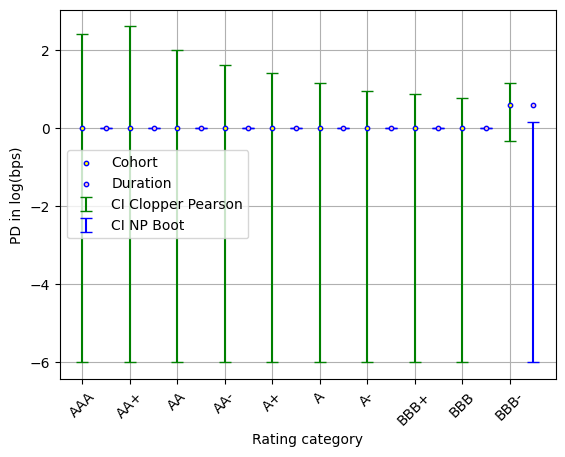

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# Exemple de données
x_labels = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-"]

# Créer un ensemble de positions entières pour chaque label avec un espacement de 2
x_positions = np.arange(0, len(x_labels) * 6, 6)

y = list(new_clopper_ci_df['mid'][:10])
confidence_interval = list(new_clopper_ci_df['lenth'][:10]/2)

y_boot = list(new_ci_boot['mid'][:10])
confidence_interval_boot = list(new_ci_boot['lenth'][:10]/2)
# Tracer les intervalles de confiance sous forme de segments
plt.errorbar(x_positions, y, yerr=confidence_interval, fmt='none', ecolor='green', capsize=4, label='CI Clopper Pearson', zorder=2)
plt.errorbar(x_positions + 3, y_boot, yerr=confidence_interval_boot, fmt='none', ecolor='blue', capsize=4, label='CI NP Boot', zorder=2)

# Ajouter des étiquettes et un titre
plt.xlabel('Rating category')
plt.ylabel('PD in log(bps)')
plt.grid(True)

# Ajouter un deuxième graphique pour la colonne 'Default' sous forme de disques entourés en jaune
y2 = list(np.log10(list(np.ones(9)) + list([table1['Cohort'][9]])))
y3 = list(np.log10(list(np.ones(9)) + list([table1['Duration'][9]])))

# Tracer les points sous forme de disques entourés en jaune à droite
plt.scatter(x_positions, y2, s=10, edgecolors='blue', facecolors='yellow', label='Cohort', zorder=3)

# Tracer les points sous forme de disques entourés en rose à gauche
plt.scatter(x_positions +3, y3, s=10, edgecolors='blue', facecolors='pink', label='Duration', zorder=3)

# Placer les x-labels au milieu entre les barres d'erreur et les points
plt.xticks(x_positions, x_labels, rotation=45, ha='center')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()


In [77]:
list(np.ones(2)) + list([1])

[1.0, 1.0, 1]

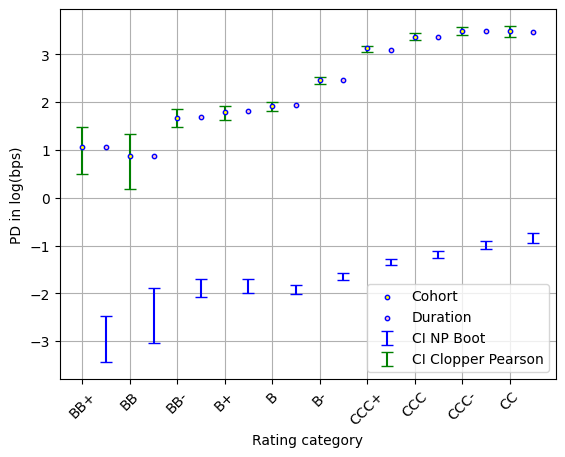

In [128]:
import matplotlib.pyplot as plt
import numpy as np

# Exemple de données
x_labels = ["BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "CCC-", "CC"]

# Créer un ensemble de positions entières pour chaque label avec un espacement de 2
x_positions = np.arange(0, len(x_labels) * 6, 6)

y = list(new_clopper_ci_df['mid'][10:])
confidence_interval = list(new_clopper_ci_df['lenth'][10:]/2)

y_boot = list(new_ci_boot['mid'][10:])
confidence_interval_boot = list(new_ci_boot['lenth'][10:]/2)
# Tracer les intervalles de confiance sous forme de segments
plt.errorbar(x_positions + 3, y_boot, yerr=confidence_interval, fmt='none', ecolor='blue', capsize=4, label='CI NP Boot', zorder=2)
# Tracer les intervalles de confiance sous forme de segments
plt.errorbar(x_positions, y, yerr=confidence_interval, fmt='none', ecolor='green', capsize=4, label='CI Clopper Pearson', zorder=2)

# Ajouter des étiquettes et un titre
plt.xlabel('Rating category')
plt.ylabel('PD in log(bps)')
plt.grid(True)

# Ajouter un deuxième graphique pour la colonne 'Default' sous forme de disques entourés en jaune
y2 = list(np.log10([table1['Cohort'][10:]]))
y3 = list(np.log10([table1['Duration'][10:]]))

# Tracer les points sous forme de disques entourés en jaune à droite
plt.scatter(x_positions, y2, s=10, edgecolors='blue', facecolors='yellow', label='Cohort', zorder=3)

# Tracer les points sous forme de disques entourés en rose à gauche
plt.scatter(x_positions +3, y3, s=10, edgecolors='blue', facecolors='pink', label='Duration', zorder=3)

# Placer les x-labels au milieu entre les barres d'erreur et les points
plt.xticks(x_positions, x_labels, rotation=45, ha='center')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()


In [79]:
y2

[array([1.06981535, 0.87614836, 1.67834509, 1.78615931, 1.91470942,
        2.4652055 , 3.12546547, 3.37270419, 3.48811664, 3.49184451])]